In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.utils import resample
import random

import matplotlib.pylab as plt

## A/B Testing
- Subjects (the thing exposed to treatment) are assigned to two groups that are treated exactly alike, except that the treatment under study differs from one group to another.
- Ideally, subjects are assigned randomly to these groups.


## Hypothesis Testing
- The null hypothesis embodies the notion that nothing significant has occurred, and any observed effect is due to random chance.
- Hypothesis testing assumes the null hypothesis is true, creates a probability model (the "null model"), and tests whether the observed effect is a reasonable outcome of that model.

## Resampling

### Permutation Test: web example

In [3]:
web_times = pd.read_csv('../../data/web_page_data.csv')
web_times['Time'] *= 100

In [4]:
print('# values from web A = ' + str(len(web_times[web_times.Page == 'Page A'])))
print('# values from web B = ' + str(len(web_times[web_times.Page == 'Page B'])))

# values from web A = 21
# values from web B = 15


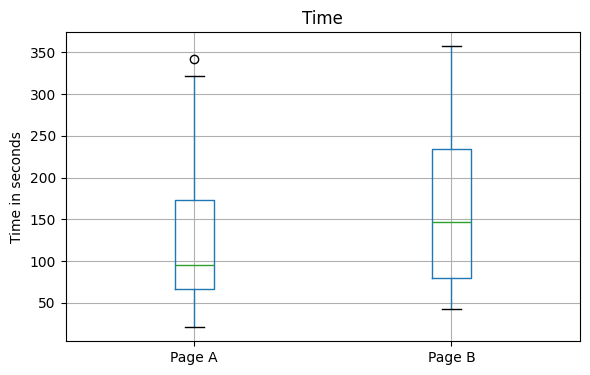

In [5]:
# We hypothesize that longer web page engagement leads to more sales. Our metric is average session time, comparing page A to page B.

ax = web_times.boxplot(by='Page', column='Time', figsize=(6,4))
ax.set_xlabel('')
ax.set_ylabel('Time in seconds')
plt.suptitle('')
plt.tight_layout()

In [6]:
mean_A = web_times[web_times['Page'] == 'Page A']['Time'].mean()
mean_B = web_times[web_times['Page'] == 'Page B']['Time'].mean()

print('Mean session times webpage A = ' + str(round(mean_A, 2)))
print('Mean session times webpage B = ' + str(mean_B))
print('Difference = ' + str(abs(round(mean_A-mean_B, 2))))

Mean session times webpage A = 126.33
Mean session times webpage B = 162.0
Difference = 35.67


Page B clearly leads to longer sessions than page A.  

Page B's session times are, on average, 35.67 seconds longer than Page A's. To determine if this difference is statistically significant or due to random chance, we can use a **permutation test**:  

- Combine all session times, shuffle them, and repeatedly divide them into two groups of 21 (Page A) and 15 (Page B). Then, compare the observed difference to the distribution of differences from the shuffled groups.

In [7]:
def perm_mean_diff(df, n_A, n_B, column):
    n = n_A + n_B
    new_A = resample(df, n_samples=n_A, replace=False)
    new_B = df.drop(new_A.index)
    return new_B[column].mean() - new_A[column].mean()

Text(0, 0.5, 'Frequency')

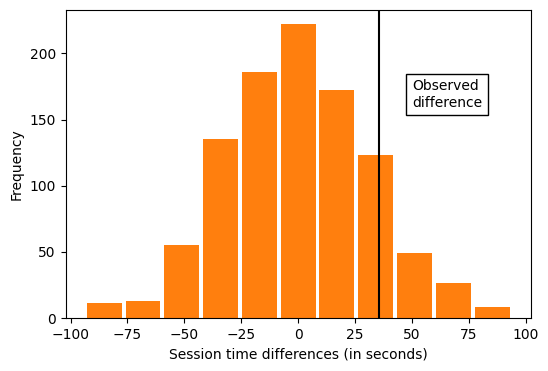

In [31]:
perm_diffs = [perm_mean_diff(web_times, 21, 15, 'Time') for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(x=perm_diffs, bins=11, rwidth=0.9, color='C1')
ax.axvline(x = mean_B - mean_A, color='black', lw=1.5)
ax.text(50, 160, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

The mean difference of random permutations often exceeds the observed difference in session times (the vertical line).  
For our results, this happens in 13% of the cases:

In [32]:
np.mean(perm_diffs > mean_B - mean_A)

0.127

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.  

### Permutation Tests: Key Takeaways for Data Science

Permutation tests are valuable for exploring random variation. They are easy to code, interpret, and explain, providing a practical alternative to formula-based statistics, which often imply unwarranted precision. Unlike traditional methods, permutation tests are versatile, handling numeric or binary data with equal or different sample sizes, without assuming normal distributions. This flexibility makes permutation tests a robust, one-size-fits-all approach to statistical inference.  

Comparing the observed value of the statistic to the resampled distribution allows you to judge whether an observed difference between samples might occur by chance.

## Significance Test: _p_-values

- Significance tests are used to determine whether an observed effect is within the range of chance variation for a null hypothesis model.
- The p-value is the probability that results as extreme as the observed results might occur, given a null hypothesis model.
- The alpha value is the threshold of “unusualness” in a null hypothesis chance model.
- Significance testing has been much more relevant for formal reporting of research than for data science (but has been fading recently, even for the former).


### E-commerce experiment example

In [10]:
ecomm_outcome = {
    'Price A': {
        'Conversion': 200, 'No conversion': 23539
    },
    'Price B': {
        'Conversion': 182, 'No conversion': 22406
    }
}

In [11]:
# We can test if the  difference in conversions between prices A and B is within the range of chancevariation, using a resampling procedure
# Null Hypothesis H0: there is no difference between the rates, any difference is just by chance

converted_rate_A = ecomm_outcome['Price A']['Conversion'] / sum(ecomm_outcome['Price A'].values())
converted_rate_B = ecomm_outcome['Price B']['Conversion'] / sum(ecomm_outcome['Price B'].values())

obs_diff_pctg = round(100 * (converted_rate_A - converted_rate_B), 4)
obs_diff_pctg


0.0368

Text(0, 0.5, 'Frequency')

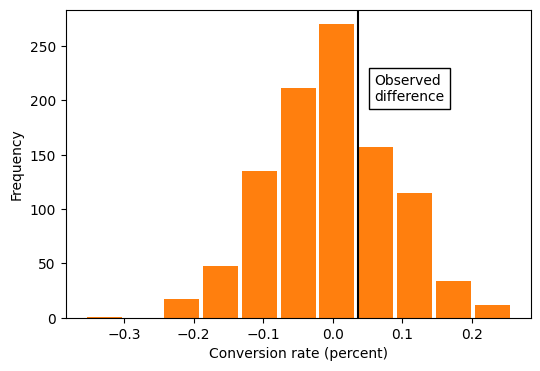

In [16]:
# rate B + 5% is approximately rate A, so:
# the following permutation tests asks: If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?

# Put cards labeled 1 and 0 in a box
total_conversions = ecomm_outcome['Price A']['Conversion'] + ecomm_outcome['Price B']['Conversion']
total_no_conversions = ecomm_outcome['Price A']['No conversion'] + ecomm_outcome['Price B']['No conversion']
conversion = [1] * total_conversions + [0] * total_no_conversions

conversion = pd.DataFrame({'Results': conversion})

n_A = sum(ecomm_outcome['Price A'].values())
n_B = sum(ecomm_outcome['Price B'].values())


# Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
# Record the number of 1s in the remaining 22,588 (same n as price B). a 1000 times

perm_diffs = [100 * perm_mean_diff(conversion, n_A, n_B, 'Results') for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(x=perm_diffs, bins=11, rwidth=0.9, color='C1')
ax.axvline(x=obs_diff_pctg, color='black', lw=1.5)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')


# How often was the difference >= 0.0368?


In [17]:
# We estimate the p-value from our permutation test by determining the frequency with which the chance model yields a result more extreme than the observed result.
# This is calculated as the proportion of times the permutation test generates a difference equal to or greater than the observed difference.

np.mean([diff >= obs_diff_pctg for diff in perm_diffs])

0.318

The p-value is 0.318, which means that we would expect to achieve a result more extreme than the observed by random chance over 30% of the time.  

Taking a 0.05 threshold value (_alpha_), our _p_-value was greater, and we cannot reject the null hypothesis. This means that the observed difference in your ecommerce experiment is not statistically significant, and it could have occurred by chance. 

## t-Tests

- t-Tests are statistical tools used to determine if there is a significant difference between the means of two groups.  
- These tests help in hypothesis testing by evaluating if any observed differences are likely due to chance or if they reflect true differences in the populations being studied.
- Before the advent of computers, resampling tests were not practical, and statisticians used standard reference distributions. We use the t-statistic: standardized version of common test statistics such as means.

In [30]:
ttest = stats.ttest_ind(web_times[web_times.Page == 'Page A'].Time,
                      web_times[web_times.Page == 'Page B'].Time, equal_var=False)
print(f'p-value for single sided test: {ttest.pvalue / 2:.4f}') # divide by 2 because its one-tailed test

p-value for single sided test: 0.1408


The alternative hypothesis is that there is a significant difference between group means (the session time mean for page A is less than that for page B).  

The p-value of 0.1408 is fairly close to the permutation test p-values of 0.127 of the web session times tested before.  

A non-significant p-value (e.g., 0.1408) indicates that the observed difference in means could be due to random chance, thus failing to reject the null hypothesis.

## ANOVA

In [12]:
web_stickiness = pd.read_csv('../../data/four_sessions.csv')
for page in range(1,5):
    print(len(web_stickiness[web_stickiness.Page == ('Page '+str(page))]))

5
5
5
5


Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


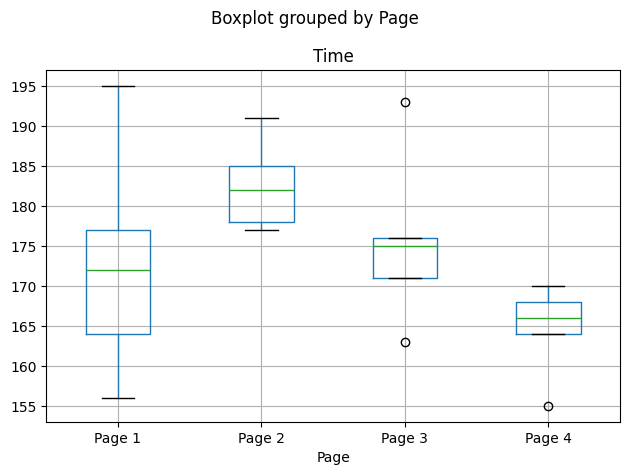

In [39]:
# We have 4 columns of different pages with 5 values each
observed_var = web_stickiness.groupby('Page')['Time'].mean().var()
print('Observed means:', web_stickiness.groupby('Page').mean().Time.values)
print('Variance:', observed_var)

ax = plt.subplot()
web_stickiness.boxplot(ax=ax, by='Page', column='Time')
plt.tight_layout()


In [53]:
# For the ANOVA test, take the whole shuffled sample and draw out 4 samples of 5 values each

df = web_stickiness.copy()
perm_vars = []
for _ in range(1000):
    df['Time'] = np.random.permutation(df['Time'])
    perm_vars.append(df.groupby('Page')['Time'].mean().var())


# What proportion of the time did the resampled variance exceed the observed variance? This is the p-value.
p_value = np.mean([(var > observed_var) for var in perm_vars])
p_value


0.089

The p-value is 0.089, which means that about 9% of the time, we could observe the same difference in response rates among the four pages just by chance, assuming there's actually no difference in stickiness between the pages. Since this falls short of the typical statistical threshold of 5%, we conclude that the difference among the four pages could likely have occurred by chance.

## Chi-Square Test

- Chi-square and Fisher’s exact tests determine if observed effects are genuine or due to chance. Data science aims to find the best treatment, with multi-armed bandits being more effective for this goal.

- These tests help determine sample sizes for web experiments with low click rates, ensuring experiments have enough power to detect meaningful effects. 

- In data science, chi-square tests filter significant effects or features. They are used in spatial statistics to detect patterns (e.g., are crimes concentrated in a certain area to a greater degree than random chance would allow?) and in machine learning for feature selection, identifying unusual class prevalence.

- The chi-square distribution is the reference distribution (which embodies the assumption of independence) to which the observed calculated chi-square statistic must be compared.

In [4]:
obs_web_stats = pd.DataFrame({
    '': ['Click', 'No-click'],
    'Headline A': [14, 986],
    'Headline B': [8, 992],
    'Headline C': [12, 988]
})
obs_web_stats.set_index('', inplace=True)
obs_web_stats

,Headline A,Headline B,Headline C
,,,
Click,14,8,12
No-click,986,992,988


The headlines seem to differ, with Headline A nearly doubling B's click rate. To test if this difference is significant, we use a resampling procedure. Under the null hypothesis that all headlines have the same click rate (34/3,000), we calculate the expected distribution.

In [5]:
expected_web_stats = obs_web_stats.copy()
expected_web_stats.loc['Click']= 34/3000 * 1000
expected_web_stats.loc['No-click']= (3000-34)/3000 * 1000 # each web had 1000 visitors
expected_web_stats

# Expected contingency table of H0:

/tmp/ipykernel_5779/322952934.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.333333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expected_web_stats.loc['Click']= 34/3000 * 1000
/tmp/ipykernel_5779/322952934.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.333333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expected_web_stats.loc['Click']= 34/3000 * 1000
/tmp/ipykernel_5779/322952934.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.333333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expected_web_stats.loc['Click']= 34/3000 * 1000


,Headline A,Headline B,Headline C
,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [6]:
observed = obs_web_stats.to_numpy()
expected = expected_web_stats.to_numpy()

pearson_residual = (observed - expected)/np.sqrt(expected)

pearson_residual_df = pd.DataFrame(index=obs_web_stats.index,
                                columns=obs_web_stats.columns,
                                data=np.round(pearson_residual,4))
pearson_residual_df

,Headline A,Headline B,Headline C
,,,
Click,0.7921,-0.9901,0.1980
No-click,-0.0848,0.1060,-0.0212


In [8]:
# The chi-square statistic is defined as the sum of the squared Pearson residuals

chi2 = sum(sum(np.square(pearson_residual)))
chi2.round(4)

1.6659

The chi-square statistic (a measure of the extent to which some observed data departs from expectation) for this example is 1.666.  

Is that more than could reasonably occur in a chance model? We can test it with this resampling algorithm:

In [19]:
# 1- Create a box with 34 clicks and 2966 no-clicks
box = [1] * 34
box.extend([0] * 2996)

# 2- Shuffle, take three separate samples of 1000, and count the clicks in each
np.random.shuffle(box)

# 3- Find the squared differences between the shuffled counts and the expected counts and sum them
def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(obs_web_stats.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
    sum(random.sample(box, 1000)),
    sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

# 4- Repeat steps 2 and 3, say, 1,000 times.
perm_chi2 = [perm_fun(box) for _ in range(2000)]

# 5. How often does the resampled sum of squared deviations exceed the observed? That’s the p-value
p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {p_value:.4f}')


Observed chi2: 1.6659
Resampled p-value: 0.4830


Since the p-value (0.4830) is much higher than the 0.05 significance levels, we fail to reject the null hypothesis: the differences in click rates among the three headlines are not statistically significant, and the variations observed are likely due to random variation rather than a real difference in effectiveness among the headlines.

Asymptotic statistical theory shows that the distribution of the chi-square statistic
can be approximated by a chi-square distribution

In [45]:
chisq_stat, pvalue, dof, expected_freq = stats.chi2_contingency(obs_web_stats)

print(f'Observed chi2: {chisq_stat:.4f}')
print(f'p-value: {pvalue:.4f}')
# pvalue slightly less than the resampling pvalue because the chisquare distrib is just an approximation of the actual distrib

Observed chi2: 1.6659
p-value: 0.4348


### Another example: scientific fraud of Thereza Imanishi-Kari

In [46]:
# Observed frequencies of interior digits
observed_freq = [14, 71, 7, 65, 23, 19, 12, 45, 53, 6]

# Expected frequency for each digit in a uniform distribution
total_digits = sum(observed_freq)
expected_freq = [total_digits / 10] * 10

# use stats.chisquare for single categorical variable and compare observed and expected
chi2test = stats.chisquare(f_obs= observed_freq, f_exp=expected_freq)
chi2test.statistic, chi2test.pvalue

(174.36507936507934, 7.59531890073772e-33)

The p-value, 7.60×10^−33 (= 0.000000...), is far below significance thresholds like 0.05 or even 0.001, indicating **strong evidence against the null hypothesis** (that any variation observed in the distribution of interior digits is merely due to random chance). This suggests the data likely deviate from a uniform distribution, possibly due to manipulation or fabrication.  

This also could've been testes with a resampling approach of Chi-Square.

## Power and sample size

- Finding out how big a sample size you need requires thinking ahead to the statistical test you plan to conduct. 
- You must specify the minimum size of the effect that you want to detect. 
- You must also specify the required probability of detecting that effect size (power). 
- Finally, you must specify the significance level (alpha) at which the test will be conducted.

In [3]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
 alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


#### Tests summary:
- **Permutation tests** are useful for comparing means or other statistics between two groups when you want to avoid assumptions about the data distribution.
- **Resampling procedures** help assess the significance of observed differences in proportions or rates, particularly useful in A/B testing scenarios.
- **Chi-square tests for independence** are used when you want to determine if there is an association between two categorical variables.
- **Chi-square tests for goodness of fit** are used to see if a single categorical variable's distribution matches a theoretical distribution. ​

#### Chapter summary:
Experimental design principles —randomizing subjects into groups with different treatments— help draw valid conclusions about treatment effectiveness. Including a control treatment of “no change” is ideal. The formality about statistical inference and its theory behind, is mostly unneeded from a data science perspective. However, acknowledging random variation's potential to mislead is crucial. Intuitive resampling methods (permutation and bootstrap) enable data scientists to assess the impact of chance variation on their analyses.